# SpikeInterface pipeline for Brody Lab

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

import spikeextractors as se  # for reading raw data
import spiketoolkit as st  # pre- and post- processed, validation, and curation
import spikesorters as ss
import spikecomparison as sc  # ensemble sorting and spike train comparisons
import spikewidgets as sw  # visualizations

from brody_lab_to_nwb import make_extractor, get_lfp

%matplotlib notebook

### Set global paramaters

In [2]:
n_jobs = 2  # Jobs for parallelization
chunk_mb = 1000  # RAM per job

verbose = True
use_memmap = False  # Enable memmap caching (recommended for Linux/macOS)

## 1a) Load AP recordings, LF recordings

### Choose one of the following formats

In [3]:
base_path = Path("E:/Brody")

spikeglx_folder_name = "A242_2019_05_30"  # or A256_2020_10_07, T219_2019_11_22
spikeglx_session_name = "2019-05-30_g0"  # usually the same as spikeglx_folder_path, except for A242
spikeglx_file_path = (
    base_path / "Chronic Rat Neuropixels (Poisson Clicks Task)" / spikeglx_folder_name / "Raw" 
    / spikeglx_session_name / f"{spikeglx_session_name}_imec0" / f"{spikeglx_session_name}_t0.imec0.ap.bin"
)
spikeglx_probe_file_path = None  # SpikeGLX contains positions naturally

spikegadgets_session_name = "W122_06_09_2019_1_fromSD"  # or W122_09_02_2019_1_fromSD
spikegadgets_file_path = base_path / "WirelessTetrodes" / f"{spikegadgets_session_name}.rec"
spikegadgets_probe_file_path = None  # TODO

neuralynx_session_name = "A182_2018_10_05"  # A182_2018_10_05 or K236_2017_09_06
neuralynx_folder_path = base_path / "Neuralynx Tetrode Data" / neuralynx_session_name / "Raw"
neuralynx_probe_file_path = "D:/GitHub/brody-lab-to-nwb/probe_files/neuralynx_tetrode_64.prb"

### Make spikeinterface folders

In [4]:
recording_folder = spikeglx_file_path.parent
spikeinterface_folder = recording_folder / "spikeinterface"
spikeinterface_folder.mkdir(parents=True, exist_ok=True)

### (optional) stub recording for fast testing; set to False for running processing pipeline on entire data

In [5]:
stub_test = True
nsec_stub = 30  # seconds

### Make RecordingExtractor

In [6]:
recording = make_extractor(file_or_folder_path=spikeglx_file_path, probe_file_path=spikeglx_probe_file_path)

if stub_test:
    recording = se.SubRecordingExtractor(recording, end_frame=int(nsec_stub*recording.get_sampling_frequency()))

In [7]:
print(f"Sampling frequency AP: {recording.get_sampling_frequency()}")

Sampling frequency AP: 30000.564435


### Inspect electrode geometry

<IPython.core.display.Javascript object>


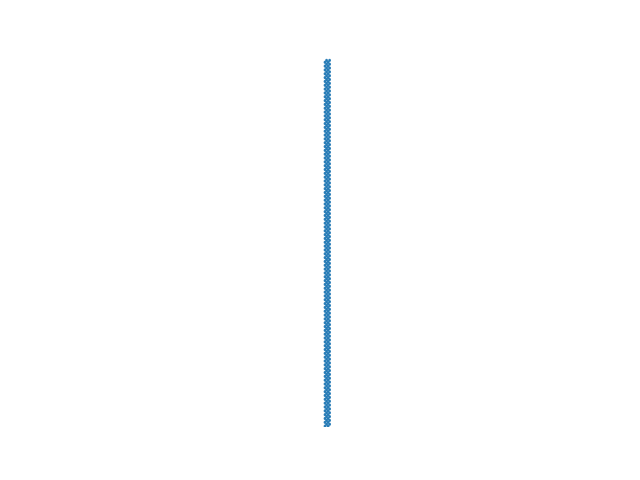

In [21]:
sw.plot_electrode_geometry(recording)

### Inspect signals

<IPython.core.display.Javascript object>


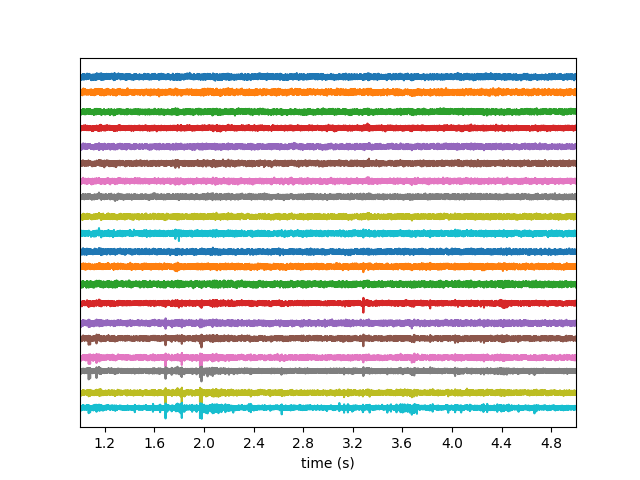

In [9]:
w_ts_ap = sw.plot_timeseries(recording, channel_ids=recording.get_channel_ids()[:20], trange=[1, 5])

### Get LFP
#### See all filter options from st.preprocessing.bandpass?

In [10]:
filter_opts = dict(
    freq_min_lfp = 1,
    freq_max_lfp = 300,
    freq_resample_lfp = 1000.
)

In [11]:
recording_lfp = get_lfp(file_or_folder_path=spikeglx_file_path, probe_file_path=spikeglx_probe_file_path, filter_opts=filter_opts)

<IPython.core.display.Javascript object>


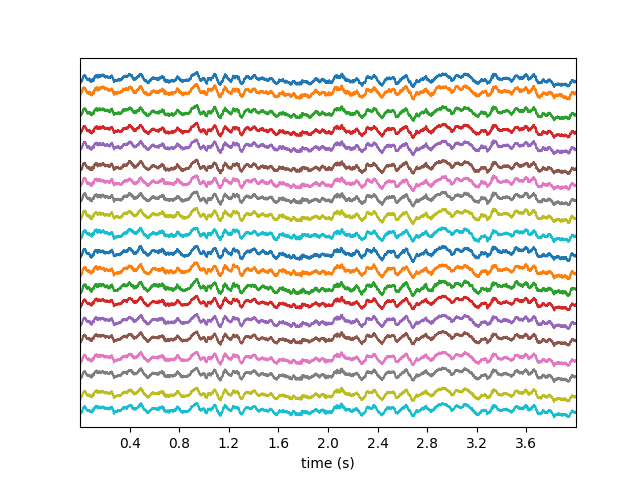

In [12]:
w_ts_lf = sw.plot_timeseries(recording_lfp, channel_ids=recording_lfp.get_channel_ids()[:20])

## 2) Pre-processing

In [17]:
apply_bandpass = True
apply_cmr = False  # Temporary until fix on spiketoolkits for SpikeGLX only

In [18]:
if apply_bandpass:
    recording_processed = st.preprocessing.bandpass_filter(recording)
else:
    recording_processed = recording

if apply_cmr:
    recording_processed = st.preprocessing.common_reference(recording_processed)
else:
    recording_processed = recording_processed

In [19]:
rates, amps = st.postprocessing.compute_channel_spiking_activity(
    start_frame=0,
    end_frame=recording_processed.get_num_frames(), 
    detect_threshold=5,
    recompute_info=True,
    recording=recording_processed,
    n_jobs=n_jobs,
    chunk_mb=chunk_mb,
    verbose=verbose
)

Number of chunks: 3 - Number of jobs: 2


<IPython.core.display.Javascript object>


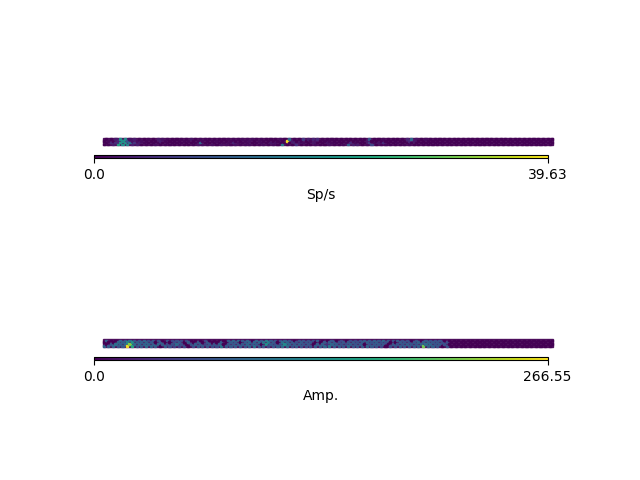

In [20]:
fig, axs = plt.subplots(nrows=2)
sw.plot_activity_map(recording_processed, activity="rate", colorbar=True, ax=axs[0], transpose=True, colorbar_orientation="horizontal")
sw.plot_activity_map(recording_processed, activity="amplitude", colorbar=True, ax=axs[1], transpose=True, colorbar_orientation="horizontal")

## 3) Run spike sorters

In [22]:
sorter_list = [
    #"herdingspikes",
    #"tridesclous",
    "ironclust",
]

ss.IronClustSorter.set_ironclust_path("D:/GitHub/ironclust")

Setting IRONCLUST_PATH environment variable for subprocess calls to: D:\GitHub\ironclust


In [23]:
# Inspect sorter-specific parameters and defaults
for sorter in sorter_list:
    print(f"{sorter} params description:")
    pprint(ss.get_params_description(sorter))
    print("Default params:")
    pprint(ss.get_default_params(sorter))    

ironclust params description:
{'adjacency_radius': 'Use -1 to include all channels in every neighborhood',
 'adjacency_radius_out': 'Use -1 to include all channels in every neighborhood',
 'batch_sec_drift': 'Batch duration in seconds. clustering time duration',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'clip_post': 'Post-peak clip duration in ms',
 'clip_pre': 'Pre-peak clip duration in ms',
 'common_ref_type': 'Common reference type: none, mean, median, trimmean',
 'delta_cut': 'Cluster detection threshold (delta-cutoff)',
 'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the '
                'sign of the spikes in the recording',
 'detect_threshold': 'detection threshold',
 'fGpu': 'Use GPU if True',
 'fParfor': 'Parfor loop',
 'feature_type': 'gpca, pca, vpp, vmin, vminmax, cov, energy, xcov',
 'fft_thresh': 'FFT-based noise peak threshold',
 'fft_thresh_low': 'FFT-based noise peak lower threshold (set to 0 to disable '
 

In [24]:
# user-specific parameters
sorter_params = dict(
    herdingspikes=dict(filter=False),
    tridesclous=dict(n_jobs_bin=n_jobs, chunk_mb=chunk_mb)
    #ironclust=dict(n_jobs_bin=n_jobs, chunk_mb=chunk_mb)
)

In [26]:
sorting_outputs = ss.run_sorters(
    sorter_list=sorter_list, 
    recording_dict_or_list=dict(rec0=recording_processed),
    working_folder=spikeinterface_folder / "working3",
    mode="overwrite", # change to "keep" to avoid repeating the spike sorting
    sorter_params=sorter_params,
    verbose=verbose,
    run_sorter_kwargs=dict(raise_error=False)
)

Writing to binary .dat file: 100%|#######################################################| 3/3 [00:38<00:00, 12.85s/it]


Warning! The recording is already filtered, but Ironclust filter is enabled. You can disable filters by setting 'filter' parameter to False
Num. channels = 384, Num. timepoints = 900016, duration = 0.49999948164864144 minutes
Creating argfile.txt...
Running ironclust in E:\Brody\Chronic Rat Neuropixels (Poisson Clicks Task)\A242_2019_05_30\Raw\2019-05-30_g0\2019-05-30_g0_imec0\spikeinterface\working3\rec0\ironclust\tmp...
RUNNING SHELL SCRIPT: E:\Brody\Chronic Rat Neuropixels (Poisson Clicks Task)\A242_2019_05_30\Raw\2019-05-30_g0\2019-05-30_g0_imec0\spikeinterface\working3\rec0\ironclust\run_ironclust.bat


(base2) D:\GitHub\brody-lab-to-nwb\notebooks>E:



(base2) E:\>cd E:\Brody\Chronic Rat Neuropixels (Poisson Clicks Task)\A242_2019_05_30\Raw\2019-05-30_g0\2019-05-30_g0_imec0\spikeinterface\working3\rec0\ironclust\tmp 



(base2) E:\Brody\Chronic Rat Neuropixels (Poisson Clicks Task)\A242_2019_05_30\Raw\2019-05-30_g0\2019-05-30_g0_imec0\spikeinterface\working3\rec0\ironclust\tmp>ma

ironclust run time 108.11s


In [27]:
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    print(f"{sorter} found {len(sorting.get_unit_ids())} units")
    
    # tridesclous sometimes has empty clusters
    if sorter == "tridesclous":
        active_units = []
        for u in sorting.get_unit_ids():
            if len(sorting.get_unit_spike_train(u)) > 0:
                active_units.append(u)

        if len(active_units) < len(sorting.get_unit_ids()):
            sorting_outputs[result_name] = se.SubSortingExtractor(sorting, unit_ids=active_units)
            print(f"{sorter} found {len(active_units)} units after removing empty")

ironclust found 12 units


## 4) Post-processing: extract waveforms, templates, quality metrics, extracellular features

### Set quality metric list
#### Reference: https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html

In [28]:
print(f"Available quality metrics: {st.validation.get_quality_metrics_list()}")

Available quality metrics: ['num_spikes', 'firing_rate', 'presence_ratio', 'isi_violation', 'amplitude_cutoff', 'snr', 'max_drift', 'cumulative_drift', 'silhouette_score', 'isolation_distance', 'l_ratio', 'd_prime', 'noise_overlap', 'nn_hit_rate', 'nn_miss_rate']


In [29]:
# Specify a subset of these metrics
qm_list = ['snr', 'isi_violation', 'firing_rate']

### Set extracellular features
#### Reference: https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms

In [30]:
print(f"Available quality metrics: {st.postprocessing.get_template_features_list()}")

Available quality metrics: ['peak_to_valley', 'halfwidth', 'peak_trough_ratio', 'repolarization_slope', 'recovery_slope']


In [31]:
# Specify a subset of these features
ecf_list = ['peak_to_valley', 'halfwidth']

### Set postprocessing parameters

In [32]:
postprocessing_params = st.postprocessing.get_postprocessing_params()
pprint(f"Default parameters: {postprocessing_params}")

("Default parameters: {'grouping_property': None, 'ms_before': 3.0, "
 "'ms_after': 3.0, 'dtype': None, 'compute_property_from_recording': False, "
 "'n_jobs': None, 'max_channels_per_waveforms': None, 'method': 'absolute', "
 "'peak': 'both', 'frames_before': 3, 'frames_after': 3, 'n_comp': 3, "
 "'by_electrode': True, 'max_spikes_for_pca': 5000, 'whiten': False, "
 "'max_spikes_per_unit': 300, 'recompute_info': False, "
 "'save_property_or_features': True, 'memmap': True, 'seed': 0, 'verbose': "
 "False, 'joblib_backend': 'loky'}")


In [33]:
postprocessing_params['max_spikes_per_unit'] = 1000  # with None, all waveforms are extracted
postprocessing_params['n_jobs'] = n_jobs
postprocessing_params['chunk_mb'] = chunk_mb
postprocessing_params['verbose'] = verbose
postprocessing_params['recompute_info'] = True
postprocessing_params['memmap'] = use_memmap

export_to_phy = False

### Postprocess all sorting outputs

In [34]:
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    print(f"Postprocessing recording {rec_name} sorted with {sorter}")
    tmp_folder = spikeinterface_folder / 'tmp' / sorter
    tmp_folder.mkdir(parents=True, exist_ok=True)
    
    # set local tmp folder
    sorting.set_tmp_folder(tmp_folder)
    
    # compute waveforms
    waveforms = st.postprocessing.get_unit_waveforms(recording_processed, sorting, **postprocessing_params)
    
    # compute templates
    templates = st.postprocessing.get_unit_templates(recording_processed, sorting, **postprocessing_params)
    
    # compute metrics
    qm = st.validation.compute_quality_metrics(
        sorting,
        recording=recording_processed, 
        metric_names=qm_list,
        as_dataframe=True
    )
    
    # compute features
    ecf = st.postprocessing.compute_unit_template_features(
        recording_processed,
        sorting,
        feature_names=ecf_list,
        as_dataframe=True
    )
    
    # export to phy - can be expensive, disable if not used
    if export_to_phy:
        phy_folder = spikeinterface_folder / 'phy' / sorter
        phy_folder.mkdir(parents=True, exist_ok=True)
        st.postprocessing.export_to_phy(
            recording_processed,
            sorting,
            phy_folder,
            compute_pc_features=False,
            compute_amplitudes=False,
            save_property_or_features=False
        )

Postprocessing recording rec0 sorted with ironclust
Number of chunks: 3 - Number of jobs: 2
Number of chunks: 3 - Number of jobs: 2


### Visualize templates

<IPython.core.display.Javascript object>


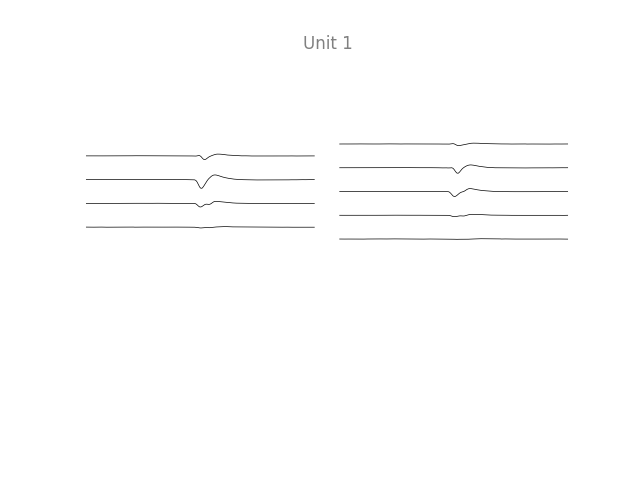

In [42]:
sorting_ic = sorting_outputs[("rec0", "ironclust")]
w = sw.plot_unit_templates(
    recording_processed,
    sorting_ic,
    unit_ids=[1],
    radius=100,  # This is spatial distance specifying channels around the unit - default is None
    lw=0.5
)
#w.figure.set_size_inches((5,15))  # this can be handy if radius=None above, to give a better visual of probe laayout

### Run phy and load curated data

####  Reference: https://phy.readthedocs.io/en/latest/

In [ ]:
!phy template-gui spikeinterface/phy/ironclust/params.py

In [ ]:
sorting_manual_curated = se.PhySortingExtractor(phy_folder, exclude_cluster_groups=['noise'])

In [ ]:
print(f"ironclust found {len(sorting_manual_curated.get_unit_ids())} units after manual curation")

## 5) Ensemble spike sorting

#### If using more than one spike sorter, this automated method has been shown to give similar results to manual curation under certain conditions: https://elifesciences.org/articles/61834

In [ ]:
if len(sorting_outputs) > 1:
    # retrieve sortings and sorter names
    sorting_list = []
    sorter_names_comp = []
    for result_name, sorting in sorting_outputs.items():
        rec_name, sorter = result_name
        sorting_list.append(sorting)
        sorter_names_comp.append(sorter)
        
    # run multisorting comparison
    mcmp = sc.compare_multiple_sorters(sorting_list=sorting_list, name_list=sorter_names_comp)
    
    # plot agreement results
    w_agr = sw.plot_multicomp_agreement(mcmp)
    
    # extract ensamble sorting
    sorting_ensemble = mcmp.get_agreement_sorting(minimum_agreement_count=2)
    
    print(f"Ensemble sorting among {sorter_list} found: {len(sorting_ensemble.get_unit_ids())} units")
    sw.plot_rasters(sorting_ensemble)

# 6) Automatic curation
### Visualize metrics

In [36]:
display(qm)

,firing_rate,isi_violation,snr
0,2160.402240,0.155239,0.199996
1,18.566686,0.000000,22.838339
2,85.200088,0.403990,1.198588
3,13.333347,0.000000,6.949437
4,205.400213,0.423187,1.723836
5,141.200146,0.497623,1.045528
6,13.566681,0.183141,8.138689
7,85.233422,0.355728,0.877503
8,125.833464,0.416539,1.267290
9,178.433518,0.486656,1.419744


In [37]:
display(ecf)

,peak_to_valley,halfwidth
0,0.001233,0.004833
1,0.000367,0.000200
2,0.000500,0.000233
3,0.000333,0.000200
4,0.000300,0.000167
5,0.000233,0.000167
6,0.001533,0.000133
7,0.000300,0.000200
8,0.000167,0.000133
9,0.000200,0.000133


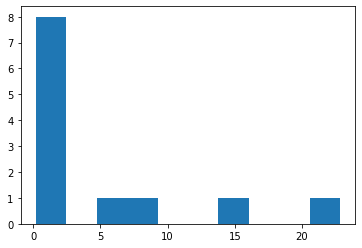

In [44]:
%matplotlib inline

plt.hist(qm["snr"])
plt.show()

### Set thresholds based on inspection

In [45]:
firing_rate_threshold = 2160
isi_violation_threshold = 0.5
snr_threshold = 1

In [46]:
sorting_auto_curated = []
sorter_names_curation = []
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    sorter_names_curation.append(sorter)
    
    # firing rate threshold
    sorting_curated = st.curation.threshold_firing_rates(
        sorting,
        duration_in_frames=recording_processed.get_num_frames(),
        threshold=firing_rate_threshold, 
        threshold_sign="greater"
    )
    print(f"{sorter} found {len(sorting_curated.get_unit_ids())} units after thresholding firing rates")
    
    # isi violation threshold
    sorting_curated = st.curation.threshold_isi_violations(
        sorting_curated,
        duration_in_frames=recording_processed.get_num_frames(),
        threshold=isi_violation_threshold, 
        threshold_sign="greater"
    )
    print(f"{sorter} found {len(sorting_curated.get_unit_ids())} units after thresholding isi violations")
    
    # snr threshold
    sorting_curated = st.curation.threshold_snrs(
        sorting_curated,
        recording=recording_processed,
        threshold=snr_threshold, 
        threshold_sign="less"
    )
    sorting_auto_curated.append(sorting_curated)
    print(f"{sorter} found {len(sorting_curated.get_unit_ids())} units after thresholding snr")

ironclust found 11 units after thresholding firing rates
ironclust found 11 units after thresholding isi violations
ironclust found 10 units after thresholding snr


# 7) Save to NWB; writes only the spikes

In [47]:
# The name of the NWBFile containing behavioral and/or full recording data
nwbfile_path = base_path.parent / f"Brody_PoissonClicks_{spikeglx_session_name}_stub_rendered.nwb"

# Choose the sorting extractor from the notebook environment you would like to write to NWB
#chosen_sorting_extractor = sorting_outputs[("rec0", "tridesclous")]
chosen_sorting_extractor = sorting_curated

se.NwbSortingExtractor.write_sorting(
    sorting=chosen_sorting_extractor,
    save_path=nwbfile_path,
    overwrite=True,  # this appends the file. True would write a new file,
    skip_features=["waveforms"]
)

D:\Users\Raven\anaconda3\envs\base2\lib\site-packages\pynwb\file.py:752: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
